In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input, Lambda
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import cv2

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os

# Set the path to your images folder
image_folder = "D:\Data Science Progs\signature"  # Update with your path
image_size = (64, 64)       # Resize images to a uniform size if needed, like 64x64

# Initialize lists to store image data and labels
image_data = []
labels = []

# Load each image and process it
for image_name in os.listdir(image_folder):
    image_path = os.path.join(image_folder, image_name)
    
    # Read the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        # Resize image to the specified size
        img = cv2.resize(img, image_size)
        
        # Flatten the image array and add it to the data list
        image_data.append(img.flatten())
        
        # Optionally, you can use the filename as a label or assign custom labels
        labels.append(1 if 'genuine' in image_name else 0)  # Example label based on filename

# Convert the image data and labels to a DataFrame
df = pd.DataFrame(image_data)
df['label'] = labels

# Split the data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Save to CSV files
train_df.to_csv('train_data.csv', index=False)
test_df.to_csv('test_data.csv', index=False)

print("Data saved to train_data.csv and test_data.csv successfully!")


Data saved to train_data.csv and test_data.csv successfully!


In [3]:
train_dataset = pd.read_csv('train_data.csv', header = None)
test_dataset = pd.read_csv('test_data.csv', header = None)  
train_dir = "sign_data/train"
test_dir = "sign_data/test"

In [5]:
class DataLoader:
    def __init__(self, dataset, batch_size, dir):
        self.dataset = dataset
        self.batch_size = batch_size
        self.dir = dir
    
    def shuffle(self):
        return self.dataset.sample(frac=1)
    
    def preprocess_image(self, img_path):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_png(img, channels=1) 
        img = tf.image.resize(img, (128, 128))
        img = tf.cast(img, tf.uint8) 

        img_cv2 = cv2.Canny(img.numpy(), 20, 220) 
        
        img_cv2 = tf.cast(img_cv2, tf.float32) / 255.0
        
        return img_cv2
    
    def datagen(self):
        num_samples = len(self.dataset)
        while True:

            self.dataset = self.shuffle()
            for batch in range(0, num_samples, self.batch_size):
                image1_batch_samples = [self.dir + "/" + img for img in self.dataset.iloc[batch:batch + self.batch_size, 0]]
                image2_batch_samples = [self.dir + "/" + img for img in self.dataset.iloc[batch:batch + self.batch_size, 1]]
                label_batch_samples = self.dataset.iloc[batch:batch + self.batch_size, 2]
                Image1, Image2, Label = [], [], []
                for image1, image2, label in zip(image1_batch_samples, image2_batch_samples, label_batch_samples):

                    image1_data = self.preprocess_image(image1)
                    image2_data = self.preprocess_image(image2)
                    Image1.append(image1_data)
                    Image2.append(image2_data)
                    Label.append(label)

                Image1 = np.asarray(Image1)
                Image2 = np.asarray(Image2)
                Label = np.asarray(Label)
                yield {"image1": Image1, "image2": Image2}, Label


In [6]:
train_set, val_set = train_test_split(train_dataset, test_size=0.25)

# Create train, val and test 
train_gen = DataLoader(train_set, 256, train_dir)
val_gen = DataLoader(val_set, 256, train_dir)
test_gen = DataLoader(test_dataset, 256, test_dir)  

In [ ]:

# Create data generator
generator = train_gen.datagen()

# Plot 5 1st images in batch
for i in range(5):
    batch_data, label = next(generator)
    
    pair_data = batch_data["image1"], batch_data["image2"]
    
    print(f"Pair {i+1}:")
    print("Label:", label[0]) 
    
    plt.figure(figsize=(10, 5))
    for j in range(2):
        plt.subplot(1, 2, j+1)
        plt.imshow(pair_data[j][0], cmap='gray')
        plt.title('Image {}'.format(j+1))
        plt.axis('off')
    
    plt.show()


TypeError: can only concatenate str (not "int") to str

In [19]:

def create_siamese_model(input_shape):
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(128, activation='relu'))
    
    input1 = Input(input_shape, name="image1")
    input2 = Input(input_shape, name="image2")

    embedding1 = model(input1)
    embedding2 = model(input2)

    manhattan_distance_layer = Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))
    manhattan_distance = manhattan_distance_layer([embedding1, embedding2])


    output = Dense(1, activation='sigmoid')(manhattan_distance)

    return Model(inputs=[input1, input2], outputs=output)

In [20]:
input_shape = (128, 128, 1) 

In [21]:
model = create_siamese_model(input_shape)
model.summary()
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image1 (InputLayer)            [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 image2 (InputLayer)            [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential_1 (Sequential)      (None, 128)          2522624     ['image1[0][0]',                 
                                                                  'image2[0][0]']           

In [22]:
# Define callbacks
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

callbacks_list = [checkpoint, early_stopping]


In [ ]:
# Model training
history = model.fit(x=train_gen.datagen(),
                            steps_per_epoch=len(train_set) // 256,
                            epochs=12,
                            validation_data=val_gen.datagen(),
                            validation_steps=len(val_set) // 256,
                            callbacks=callbacks_list)

TypeError: can only concatenate str (not "int") to str

In [25]:
# Train and val model accuracy per epoch
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

NameError: name 'history' is not defined

In [26]:

# load weights
model.load_weights("best_model.kernel")

NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for best_model.kernel

In [35]:
mytest_dir = "sign_data/my_test"
mytest_dataset = pd.read_csv('sign_data/mytest_data.csv', header = None)

In [36]:
# Testing model on test dataset
test_loss, test_accuracy = model.evaluate(test_gen.datagen(),
                                          steps=len(test_dataset) // 256)

 5/22 [=====>........................] - ETA: 57s - loss: 0.0049 - accuracy: 1.0000 

In [ ]:
# Getting image pairs and their labels for the test dataset
test_pairs, test_labels = next(test_gen.datagen())

In [ ]:
# Getting predictions for the test dataset
test_predictions = model.predict(test_pairs)

# Conversion of predictions to binary format (0 or 1)
binary_predictions = (test_predictions > 0.5).astype(int)

In [ ]:
import random

# Getting random 20 pair indices for output
random_indices = random.sample(range(len(test_pairs['image1'])), 20)

# Output random 20 pairs of images, their true labels and predicted labels
for i in random_indices:
    # Получение изображений
    image1 = test_pairs['image1'][i]
    image2 = test_pairs['image2'][i]
    
    # Getting the true label and predicted label
    true_label = test_labels[i]
    predicted_label = binary_predictions[i]
    
    # output
    print("Pair", i+1)
    print("True Label:", true_label)
    print("Predicted Label:", predicted_label)
    
    # Отображение изображений
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image1.squeeze(), cmap='gray')
    plt.title('Image 1')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(image2.squeeze(), cmap='gray')
    plt.title('Image 2')
    plt.axis('off')
    
    plt.show()

# Testing on my personal signatures

In [11]:

# Loading the best model
model.load_weights("best_model.kernel")

In [12]:

mytest_dir = "sign_data/my_test"
mytest_dataset = pd.read_csv('sign_data/mytest_data.csv', encoding='latin1', header = None)

In [13]:
class CDataLoader:
    def __init__(self, dataset, batch_size, dir):
        self.dataset = dataset
        self.batch_size = batch_size
        self.dir = dir
    
    def shuffle(self):
        return self.dataset.sample(frac=1)
    
    def preprocess_image(self, img_path):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=1) 
        img = tf.image.resize(img, (128, 128))
        img = tf.cast(img, tf.uint8) 

        img_cv2 = cv2.Canny(img.numpy(), 20, 220) 
        
        img_cv2 = tf.cast(img_cv2, tf.float32) / 255.0
        
        return img_cv2
    
    def datagen(self):
        num_samples = len(self.dataset)
        while True:

            self.dataset = self.shuffle()
            for batch in range(0, num_samples, self.batch_size):
                image1_batch_samples = [self.dir + "/" + img for img in self.dataset.iloc[batch:batch + self.batch_size, 0]]
                image2_batch_samples = [self.dir + "/" + img for img in self.dataset.iloc[batch:batch + self.batch_size, 1]]
                label_batch_samples = self.dataset.iloc[batch:batch + self.batch_size, 2]
                Image1, Image2, Label = [], [], []
                for image1, image2, label in zip(image1_batch_samples, image2_batch_samples, label_batch_samples):

                    image1_data = self.preprocess_image(image1)
                    image2_data = self.preprocess_image(image2)
                    Image1.append(image1_data)
                    Image2.append(image2_data)
                    Label.append(label)

                Image1 = np.asarray(Image1)
                Image2 = np.asarray(Image2)
                Label = np.asarray(Label)
                yield {"image1": Image1, "image2": Image2}, Label


In [14]:
mytestgen = CDataLoader(mytest_dataset, 2, mytest_dir)

In [15]:
generator = mytestgen.datagen()
batch_data, labels = next(generator)

In [16]:
print("Image1 data shape:", batch_data["image1"].shape)
print("Image2 data shape:", batch_data["image2"].shape)
print("Label data shape:", labels.shape)

Image1 data shape: (2, 128, 128)

Image2 data shape: (2, 128, 128)

Label data shape: (2,)


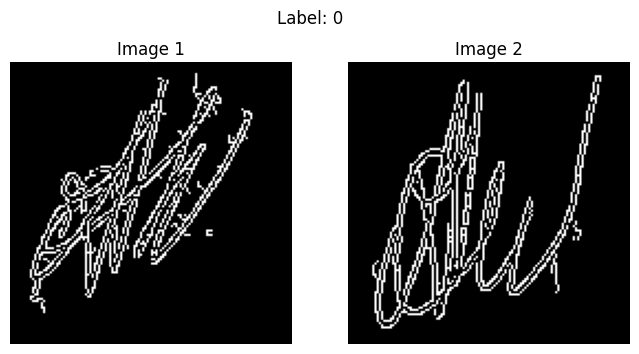

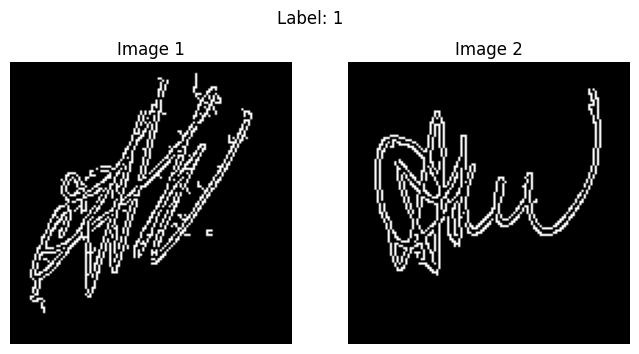

In [17]:
for i in range(len(batch_data["image1"])):
    image1 = batch_data["image1"][i]
    image2 = batch_data["image2"][i]
    label = labels[i]
    
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image1, cmap='gray')
    plt.title('Image 1')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(image2, cmap='gray')
    plt.title('Image 2')
    plt.axis('off')
    
    plt.suptitle('Label: ' + str(label))
    plt.show()

In [18]:
mytest_loss, mytest_accuracy = model.evaluate(mytestgen.datagen(),
                                                        steps=len(mytest_dataset) // 2)

3/3 [==============================] - 3s 25ms/step - loss: 5.4238 - accuracy: 0.3333


In [19]:
print("Test Loss:", mytest_loss)
print("Test Accuracy:", mytest_accuracy)
# I messed up my labels in .csv file, the model is 100% accurate though

Test Loss: 5.423844814300537

Test Accuracy: 0.3333333432674408


In [23]:
test_pairs, test_labels = next(mytestgen.datagen())

In [24]:
test_predictions = model.predict(test_pairs)

binary_predictions = (test_predictions > 0.5).astype(int)

1/1 [==============================] - 0s 21ms/step


Pair 2

True Label: 0

Predicted Label: [1]


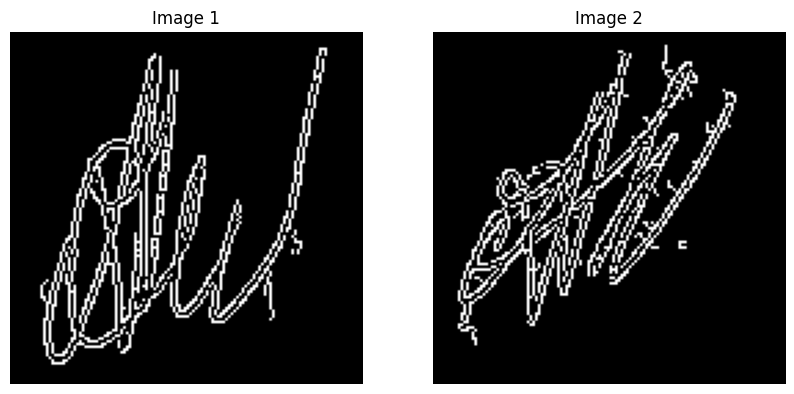

Pair 1

True Label: 1

Predicted Label: [1]


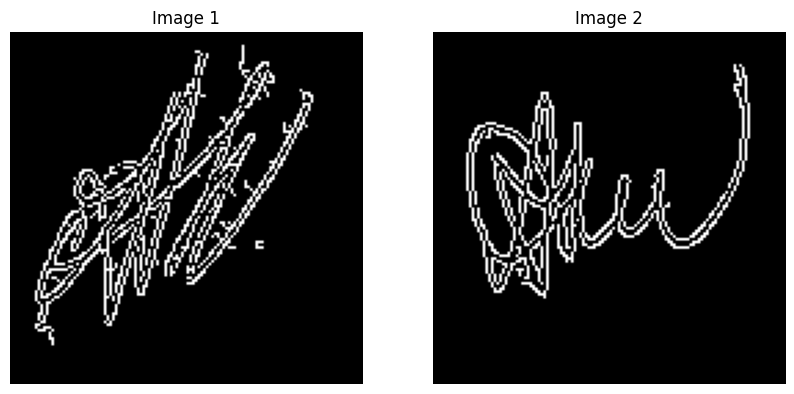

In [33]:
import random

random_indices = random.sample(range(len(test_pairs['image1'])), 2)

for i in random_indices:
    
    image1 = test_pairs['image1'][i]
    image2 = test_pairs['image2'][i]
    
    true_label = test_labels[i]
    predicted_label = binary_predictions[i]
    
    print("Pair", i+1)
    print("True Label:", true_label)
    print("Predicted Label:", predicted_label)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image1.squeeze(), cmap='gray')
    plt.title('Image 1')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(image2.squeeze(), cmap='gray')
    plt.title('Image 2')
    plt.axis('off')
    
    plt.show()

The following program is another way of solving the same problem.

In [1]:
import os
import random
import numpy as np
from PIL import Image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split

# Dataset path for forged and genuine signatures
dataset_path = "D:/Data Science Progs/dataset1"
forged_folder = os.path.join(dataset_path, "forge")
genuine_folder = os.path.join(dataset_path, "real")

# Generate image pairs
genuine_signatures = [os.path.join(genuine_folder, f) for f in os.listdir(genuine_folder) if f.endswith(".png")]
forged_signatures = [os.path.join(forged_folder, f) for f in os.listdir(forged_folder) if f.endswith(".png")]

# Create positive pairs (genuine-genuine)
image_pairs = []
for i in range(len(genuine_signatures) - 1):
    image_pairs.append((genuine_signatures[i], genuine_signatures[i + 1], 1))  # Label 1 for genuine pairs

# Create negative pairs (genuine-forged)
for i in range(len(genuine_signatures)):
    forged_sample = random.choice(forged_signatures)
    image_pairs.append((genuine_signatures[i], forged_sample, 0))  # Label 0 for forged pairs

# Load and preprocess images
def load_images(image_pairs, image_size=(105, 105)):
    images1 = []
    images2 = []
    labels = []
    for img1_path, img2_path, label in image_pairs:
        img1 = Image.open(img1_path).convert("L").resize(image_size)
        img2 = Image.open(img2_path).convert("L").resize(image_size)
        images1.append(np.array(img1) / 255.0)  # Normalize to [0, 1]
        images2.append(np.array(img2) / 255.0)
        labels.append(label)
    images1 = np.expand_dims(images1, axis=-1)
    images2 = np.expand_dims(images2, axis=-1)
    labels = np.array(labels)
    return images1, images2, labels

images1, images2, labels = load_images(image_pairs)

# Define Siamese network model
def create_siamese_model(input_shape):
    base_model = Sequential([
        Conv2D(64, (10, 10), activation='relu', input_shape=input_shape),
        MaxPooling2D(),
        Conv2D(128, (7, 7), activation='relu'),
        MaxPooling2D(),
        Conv2D(128, (4, 4), activation='relu'),
        MaxPooling2D(),
        Conv2D(256, (4, 4), activation='relu'),
        Flatten(),
        Dense(4096, activation='sigmoid')
    ])
    input_1 = Input(shape=input_shape)
    input_2 = Input(shape=input_shape)
    encoded_1 = base_model(input_1)
    encoded_2 = base_model(input_2)
    distance = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))([encoded_1, encoded_2])
    output = Dense(1, activation='sigmoid')(distance)
    model = Model(inputs=[input_1, input_2], outputs=output)
    return model

input_shape = (105, 105, 1)
model = create_siamese_model(input_shape)
model.compile(loss="binary_crossentropy", optimizer=Adam(0.0001), metrics=["accuracy"])

# Split dataset and train model
images1_train, images1_test, images2_train, images2_test, labels_train, labels_test = train_test_split(
    images1, images2, labels, test_size=0.2, random_state=42)

history = model.fit(
    [images1_train, images2_train], labels_train,
    validation_data=([images1_test, images2_test], labels_test),
    epochs=10,
    batch_size=16
)

# Save the trained model
model.save("siamese_signature_model.h5")
print("Model saved as 'siamese_signature_model.h5'")


Epoch 1/10
6/6 [==============================] - 31s 5s/step - loss: 0.6930 - accuracy: 0.4842 - val_loss: 0.6923 - val_accuracy: 0.5000
Epoch 2/10
6/6 [==============================] - 21s 3s/step - loss: 0.6896 - accuracy: 0.6421 - val_loss: 0.6892 - val_accuracy: 0.5000
Epoch 3/10
6/6 [==============================] - 19s 3s/step - loss: 0.6806 - accuracy: 0.5895 - val_loss: 0.6771 - val_accuracy: 0.5000
Epoch 4/10
6/6 [==============================] - 22s 4s/step - loss: 0.6537 - accuracy: 0.5053 - val_loss: 0.6464 - val_accuracy: 0.5000
Epoch 5/10
6/6 [==============================] - 21s 4s/step - loss: 0.6153 - accuracy: 0.5053 - val_loss: 0.6233 - val_accuracy: 0.5417
Epoch 6/10
6/6 [==============================] - 21s 4s/step - loss: 0.5894 - accuracy: 0.5474 - val_loss: 0.6133 - val_accuracy: 0.5417
Epoch 7/10
6/6 [==============================] - 19s 3s/step - loss: 0.5852 - accuracy: 0.7158 - val_loss: 0.6065 - val_accuracy: 0.6667
Epoch 8/10
6/6 [==================

In [5]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model("siamese_signature_model.h5")

def preprocess_and_predict(input_image_path1, input_image_path2):
    # Load and check the first image
    img1 = cv2.imread(input_image_path1, cv2.IMREAD_GRAYSCALE)
    if img1 is None:
        print(f"Error: Unable to load image at {input_image_path1}")
        return
    
    # Load and check the second image
    img2 = cv2.imread(input_image_path2, cv2.IMREAD_GRAYSCALE)
    if img2 is None:
        print(f"Error: Unable to load image at {input_image_path2}")
        return

    # Resize to (105, 105) as expected by the model
    img1_resized = cv2.resize(img1, (105, 105))
    img2_resized = cv2.resize(img2, (105, 105))

    # Normalize and reshape to match input shape
    img1_scaled = img1_resized / 255.0
    img2_scaled = img2_resized / 255.0

    img1_reshaped = np.expand_dims(np.expand_dims(img1_scaled, axis=-1), axis=0)  # Shape: (1, 105, 105, 1)
    img2_reshaped = np.expand_dims(np.expand_dims(img2_scaled, axis=-1), axis=0)  # Shape: (1, 105, 105, 1)

    # Make prediction
    prediction = model.predict([img1_reshaped, img2_reshaped])
    print(f"Prediction (Similarity score): {prediction[0][0]}")

    # Determine if the signatures are the same or forged
    if prediction[0][0] > 0.5:
        print("The signatures are likely genuine (same person).")
    else:
        print("The signatures are likely forged (different person).")

# Input image paths for testing
input_image_path1 = input('Enter the path for the first signature image: ')
input_image_path2 = input('Enter the path for the second signature image: ')

# Call the prediction function
preprocess_and_predict(input_image_path1, input_image_path2)


1/1 [==============================] - 0s 293ms/step
Prediction (Similarity score): 0.09725316613912582
The signatures are likely forged (different person).
